In [ ]:
import re
import os
import time
import numpy as np
import pandas as pd 
import unicodedata
import tensorflow as tf
import tensorflow.keras as krs
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import csv
from sklearn.utils import shuffle
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_file = '/content/drive/MyDrive/data/cnn_dailymail/train.csv'
validation_file = '/content/drive/MyDrive/data/cnn_dailymail/validation.csv'

### Reading the data and droppping useless columns

In [ ]:
data_unprocessed_news = pd.read_csv(train_file)
data_unprocessed_news.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
data_unprocessed_news_valid = pd.read_csv(validation_file)
data_unprocessed_news_valid.head()

,id,article,highlights
0,61df4979ac5fcc2b71be46ed6fe5a46ce7f071c3,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,21c0bd69b7e7df285c3d1b1cf56d4da925980a68,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...
2,56f340189cd128194b2e7cb8c26bb900e3a848b4,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago..."
3,00a665151b89a53e5a08a389df8334f4106494c2,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...
4,9f6fbd3c497c4d28879bebebea220884f03eb41a,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...


In [ ]:
data_unprocessed_news["article_length"] = data_unprocessed_news["article"].apply(lambda x : len(x.split(" ")))
data_unprocessed_news["highlights_length"] = data_unprocessed_news["highlights"].apply(lambda x : len(x.split(" ")))

In [ ]:
data_unprocessed_news = data_unprocessed_news[(data_unprocessed_news["article_length"]<360) & (data_unprocessed_news["highlights_length"]<60) &(data_unprocessed_news["article_length"]>100)& (data_unprocessed_news["highlights_length"]>10)]

In [ ]:
# shuffling the data 
data_unprocessed_news = shuffle(data_unprocessed_news)
data_unprocessed_news_valid = shuffle(data_unprocessed_news_valid)
data_unprocessed_news_valid = data_unprocessed_news_valid[:3600]

In [ ]:
data_unprocessed_news = data_unprocessed_news[["article","highlights"]]
data_unprocessed_news_valid = data_unprocessed_news_valid[["article","highlights"]]
data_unprocessed_news.columns = ["long","short"]
data_unprocessed_news_valid.columns = ["long","short"]

In [ ]:
summaries, longreview, summaries_valid, longreview_valid= pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
summaries['short'] = data_unprocessed_news['short']
longreview['long'] = data_unprocessed_news['long']
summaries_valid['short'] = data_unprocessed_news_valid['short']
longreview_valid['long'] = data_unprocessed_news_valid['long']

### Cleaning the data



In [ ]:
# replacing many abbreviations and lower casing the words
def clean_words(sentence):
    sentence = str(sentence).lower()
    sentence = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') # for converting é to e and other accented chars
    sentence = re.sub(r"http\S+","",sentence)
    sentence = re.sub(r"there's", "there is", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    sentence = re.sub(r"'til", "until", sentence)
    sentence = re.sub(r"\"", "", sentence)
    sentence = re.sub(r"\'", "", sentence)
    sentence = re.sub(r' s ', "",sentence)
    sentence = re.sub(r"&39", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"&34", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"[\[\]\\0-9()\"$#%/@;:<>{}`+=~|.!?,-]", "", sentence)
    sentence = re.sub(r"&", "", sentence)
    sentence = re.sub(r"\n", "", sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
summaries['short'] = summaries['short'].apply(lambda x: clean_words(x))
longreview['long'] = longreview['long'].apply(lambda x: clean_words(x))
summaries_valid['short'] = summaries_valid['short'].apply(lambda x: clean_words(x))
longreview_valid['long'] = longreview_valid['long'].apply(lambda x: clean_words(x))

In [ ]:
longreview.head()

,long
92492,bradford coach james lowes has put the finishi...
68527,you might call it stemwaregate a seemingly ext...
238232,arsene wenger has urged his arsenal team to us...
211750,this kitten might have just proved wrong the l...
6067,new delhi cnn indias top court thursday sente...


In [ ]:
# adding start and end token to the sentences of label 
start_token, end_token = '<startseq>' , '<endseq>'
summaries = summaries.apply(lambda x: start_token + ' ' + x + ' ' + end_token)
summaries_valid = summaries_valid.apply(lambda x: start_token + ' ' + x + ' ' + end_token)
summaries.head()

,short
92492,<startseq> scrumhalf harry siejka made nine ap...
68527,<startseq> simon pearce of vermont wins contra...
238232,<startseq> arsenal face qpr west ham and south...
211750,<startseq> owners were shocked when their pet ...
6067,<startseq> indias top court sentences sanjay d...


In [ ]:
summaries_valid

,short
4312,<startseq> soldiers revealed the tradition at ...
3570,<startseq> the sevenbedroom holwood house in k...
4549,<startseq> companies believe internal emails c...
10542,<startseq> david autry brutally assaulted las...
8075,<startseq> two siberian tigers were kept on th...
...,...
929,<startseq> white city in the honduran mosquiti...
11390,<startseq> photos of robert durst emerging fro...
9848,<startseq> joshua leinbach was in a horsedraw...
4939,<startseq> newspapers cite sources who say and...


In [ ]:
summaries_train = summaries
summaries_val = summaries_valid
longreview_train = longreview
longreview_val = longreview_valid

len(longreview_val),len(longreview_train)

(3600, 39395)

In [ ]:
longreview_train.iloc[0], summaries_train.iloc[0]

(long    bradford coach james lowes has put the finishi...
 Name: 92492, dtype: object,
 short    <startseq> scrumhalf harry siejka made nine ap...
 Name: 92492, dtype: object)

finding the maximum length of questions and answers

In [ ]:
# caculate the max length that 95% of sentences are shorter than that
def max_length(shorts, longs, prct):
    # Create a list of all the captions
    
    length_longs = list(len(d.split()) for d in longs)
    length_shorts = list(len(d.split()) for d in shorts)

    print('percentile {} of length of news: {}'.format(prct,np.percentile(length_longs, prct)))
    print('longest sentence: ', max(length_longs))
    print()
    print('percentile {} of length of summaries: {}'.format(prct,np.percentile(length_shorts, prct)))
    print('longest sentence: ', max(length_shorts))
    print()
    return int(np.percentile(length_longs, prct)),int(np.percentile(length_shorts, prct))

# selecting sentence length based on the percentile of data that fits in the length
max_len_news, max_len_summary= max_length(summaries_train['short'].to_list(), longreview_train['long'].to_list(), 90)


print('max-length longreview chosen for training: ', max_len_news)
print('max-length summaries chosen for training: ', max_len_summary)

percentile 90 of length of news: 335.0
longest sentence:  372

percentile 90 of length of summaries: 52.0
longest sentence:  67

max-length longreview chosen for training:  335
max-length summaries chosen for training:  52


In [ ]:
max_len_news =  300
max_len_summary = 50

### Dataset prepration


In [ ]:
# making a vocabulary of the words 
def create_vocab(shorts, longs = None, minimum_repeat = 3):
  
    all_captions = []
    for s in shorts:
        all_captions.append(s)

    # Consider only words which occur at least minimum_occurrence times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= minimum_repeat]
    
    vocab = list(set(vocab))
    return vocab

In [ ]:
# each word in the vocabulary must be used in the data atleast minimum_repeat times
vocab = create_vocab(summaries_train['short'].to_list()+longreview_train['long'].to_list(), minimum_repeat=5) 
# removing one character words from vocab except for 'a'
for v in vocab:
    if len(v) == 1 and v!='a' and v!='i':
        vocab.remove(v) 
        
vocab = sorted(vocab)[1:]
vocab[:10]

['****',
 '*nsync',
 '<endseq>',
 '<startseq>',
 'a',
 'a*',
 'a**',
 'a***',
 'aa',
 'aaa']

In [ ]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # making sure all the last non digit non alphabet chars are removed
tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
tokenizer.fit_on_texts(vocab)

# caculating number of words in vocabulary of encoder and decoder
encoder_vocab_size = len(tokenizer.word_index) + 1 
decoder_vocab_size = len(tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(53093, 53093)

In [ ]:
ixtoword_enc = {} # index to word dic for encoder
ixtoword_dec = {} # index to word dic for decoder

wordtoix_enc = tokenizer.word_index # word to index dic
ixtoword_enc[0] = '<PAD0>' # no word in vocab has index 0. but padding is indicated with 0
ixtoword_dec[0] = '<PAD0>' # no word in vocab has index 0. but padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword_enc[tokenizer.word_index[w]] = w
    
wordtoix_dec = tokenizer.word_index # word to index dic

for w in tokenizer.word_index:
    ixtoword_dec[tokenizer.word_index[w]] = w

In [ ]:
# assign a number to each word inorder to find it in word embeddings
inputs = tokenizer.texts_to_sequences(longreview_train['long'])
targets = tokenizer.texts_to_sequences(summaries_train['short'])
inputs_val = tokenizer.texts_to_sequences(longreview_val['long'])
targets_val = tokenizer.texts_to_sequences(summaries_val['short'])

In [ ]:
inputs = krs.preprocessing.sequence.pad_sequences(inputs, maxlen=max_len_news, padding='post', truncating='post')
targets = krs.preprocessing.sequence.pad_sequences(targets, maxlen=max_len_summary, padding='post', truncating='post')
inputs_val = krs.preprocessing.sequence.pad_sequences(inputs_val, maxlen=max_len_news, padding='post', truncating='post')
targets_val = krs.preprocessing.sequence.pad_sequences(targets_val, maxlen=max_len_summary, padding='post', truncating='post')

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64 
embedding_dim = 100 #embedding dimension

In [ ]:
# validate train split
dataset = tf.data.Dataset.from_tensor_slices((inputs,targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.from_tensor_slices((inputs_val,targets_val)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE*2)

In [ ]:
longreview_val.reset_index(inplace=True, drop=True)
summaries_val.reset_index(inplace=True, drop=True)
longreview_train.reset_index(inplace=True, drop=True)
summaries_train.reset_index(inplace=True, drop=True)

#### Embeddings preparation

In [ ]:
 # Making the embedding mtrix
def make_embedding_layer(vocab_len, wordtoix, embedding_dim=200, glove=True, glove_path= '/content/drive/MyDrive/data/glove'):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        glove_dir = glove_path
        embeddings_index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get n-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
        
        print("GloVe ",embedding_dim, ' loaded!')

    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) 
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

embeddings_encoder = make_embedding_layer(encoder_vocab_size, wordtoix_enc, embedding_dim=embedding_dim, glove=True)
embeddings_decoder = make_embedding_layer(decoder_vocab_size, wordtoix_dec, embedding_dim=embedding_dim, glove=True)


Loading glove...
GloVe  100  loaded!
Loading glove...
GloVe  100  loaded!


### Defining the model

The Hyper parameters for the model

In [ ]:
#hyper parameters
init_lr = 1e-3 #learning rate
lmbda_l2 = 0.2 #regularization parameter
d_out_rate = 0.2  #drop_out rate
num_layers = 5 #number of encoder and decoder layer
d_model = embedding_dim #input dimension
dff = 512 # number of neurons in feed forward network
num_heads = 5 

#### Scaled Dot Product
![](files/z-score.png)


The formula for attention is this one:

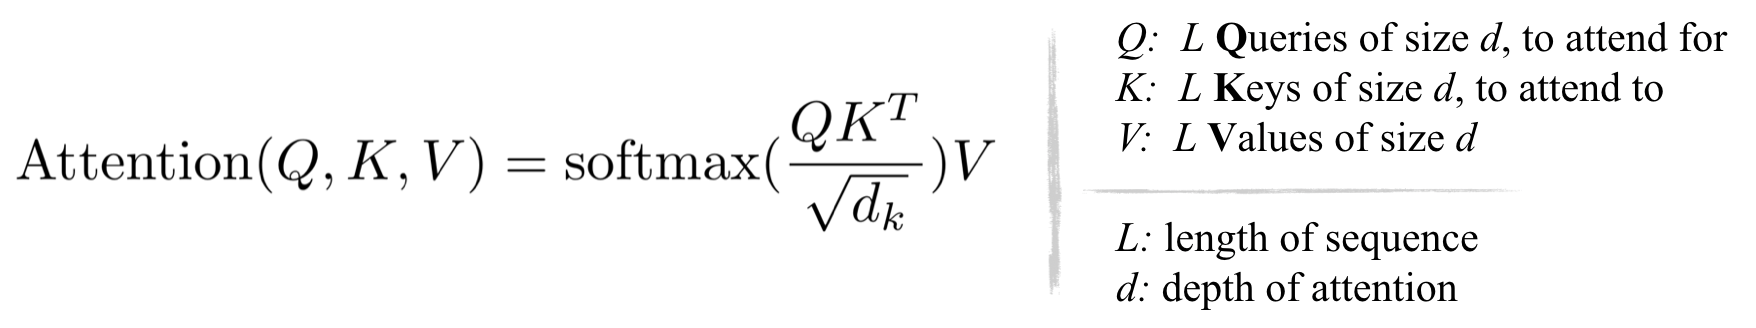

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

#### multi-headed attention
![](files/multi-head.png)

In [ ]:
class MultiHeadAttention(krs.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # The dimensions of Q, K, V are called depth

        # the input of these 3 layers are the same: X
        self.wq = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wk = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wv = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))

        self.dense = tf.keras.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    
    # reshape the Q,K,V 
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # learn the Q,K,V matrices (the layers' weightes)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # reshape them
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # the last dens layer expect one vector so we use concat
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

#### positional encoding

The formula for positional encoding is:

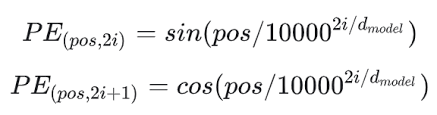

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

# The dimension of positional encodings is the same as
# the embeddings (d_model) for facilitating the summation of both.
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

#### Layers

#### transformer layers

In [ ]:
# The Point-wise feed-forward network block is essentially a 
# two-layer linear transformation which is used identically throughout the model
def point_wise_feed_forward_network(d_model, dff):
    return krs.Sequential([
        krs.layers.Dense(dff, activation='relu',kernel_regularizer=krs.regularizers.l2(l=lmbda_l2)),
        krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    ])

In [ ]:
class EncoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
   
    # it has 1 layer of multi-headed attention
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [ ]:
class DecoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
        self.dropout3 = krs.layers.Dropout(rate)
    
    # it has 2 layers of multi-headed attention
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_encoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = krs.layers.Dropout(rate)
        self.dropout_embd = krs.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x = self.dropout_embd(x, training=training) # dropout added to encoder input changed from nothing to this
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x

In [ ]:
class Decoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_decoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)] # a list of decoder layers
        self.dropout = krs.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask) # enc_output is fed into it

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights

#### Final model

In [ ]:
class Transformer(krs.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                                     target_vocab_size, pe_input, pe_target, rate=d_out_rate):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = krs.layers.Dense(target_vocab_size, kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        
        
    # training argument is used in dropout inputs
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
       
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [ ]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=max_len_news,
    pe_target=max_len_summary,
)

#### Masking


In [ ]:
# Padding mask for masking "pad" sequences so 
# they won't affect the loss
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

# Lookahead mask for masking future words from
# contributing in prediction of current words in self attention
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [ ]:
# this function is use in training step
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
        
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

#### training

In [ ]:
lr_schedule = krs.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=4000,
    decay_rate=0.95) 

In [ ]:
optimizer2 = Adam(lr_schedule , beta_1=0.9, beta_2=0.98, epsilon=1e-9) # changed to init
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none') # added softmax changed from_logits to false

In [ ]:
def loss_function(real, pred, l2= False):
 
    if l2:
        lambda_ = 0.0001
        l2_norms = [tf.nn.l2_loss(v) for v in transformer.trainable_variables]
        l2_norm = tf.reduce_sum(l2_norms)
        l2_value = lambda_ * l2_norm
        loss_ = loss_object(real, pred) + l2_value
    else:
        loss_ = loss_object(real, pred) 
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
checkpoint_path4 ="/content/drive/MyDrive/data/checkpoints4"

ckpt4 = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer2)

ckpt_manager4 = tf.train.CheckpointManager(ckpt4, checkpoint_path4, max_to_keep=100)

if ckpt_manager4.latest_checkpoint:
    ckpt4.restore(ckpt_manager4.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


#### inference

In [ ]:
def evaluate(input_document):
    input_document = tokenizer.texts_to_sequences([input_document])
    input_document = krs.preprocessing.sequence.pad_sequences(input_document, maxlen=max_len_news, 
                                                                           padding='post', truncating='post')
    
    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [tokenizer.word_index[start_token]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_len_summary):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # stop prediciting if it reached end_token
        if predicted_id == tokenizer.word_index[end_token]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # remove start_token
    return tokenizer.sequences_to_texts(summarized)[0]  # since there is just one translated document

In [ ]:
def validate():
    print('validation started ...')
    val_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset_val):    
        tar_inp = tar[:, :-1] # <startseq> hi im moein
        tar_real = tar[:, 1:] # hi im moein <endseq>

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        # Operations are recorded if they are executed within this context manager
        # and at least one of their inputs is being "watched". Trainable variables are automatically watched
        predictions, _ = transformer(
            inp, tar_inp, 
            False, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
        val_loss(loss)
    print('\n* Validation loss: {} '.format(val_loss.result()) )
    return val_loss.result()
# validate()

In [ ]:
@tf.function # Compiles a function into a callable TensorFlow graph
def train_step(inp, tar):
    tar_inp = tar[:, :-1] # <startseq> hi im moein
    tar_real = tar[:, 1:] # hi im moein <endseq>

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    # Operations are recorded if they are executed within this context manager
    # and at least one of their inputs is being "watched". Trainable variables are automatically watched
    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer2.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # mean the loss with new computed  loss of the step
    train_loss(loss)

In [ ]:
history={'val':[],'train':[]}
EPOCHS = 36
not_progressing = 0
train_loss = krs.metrics.Mean(name='train_loss')
val_loss = krs.metrics.Mean(name='val_loss')

In [ ]:
params = {
'lmbda_l2' : lmbda_l2,
'd_out_rate' :d_out_rate,
'num_layers' : num_layers ,
'd_model' : d_model  ,
'dff' : dff ,
'num_heads' : num_heads,
'init_lr':init_lr}
params

{'lmbda_l2': 0.2,
 'd_out_rate': 0.2,
 'num_layers': 5,
 'd_model': 100,
 'dff': 512,
 'num_heads': 5,
 'init_lr': 0.001}

In [ ]:
ep = 1
best_val_loss = np.inf
i1,i2,i3,i4 = np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val))

In [ ]:
def hist(history):
    plt.title('Loss')

    x= [i[0] for i in history['val']]
    y=[i[1] for i in history['val']]
    plt.plot(x,y,'x-')
    
    x= [i[0] for i in history['train']]
    y=[i[1] for i in history['train']]    
    plt.plot(x,y,'o-')

    plt.legend(['validation','train'])
    plt.show()
    print('smallest val loss:', sorted(history['val'],key=lambda x: x[1])[0])

{'lmbda_l2': 0.2, 'd_out_rate': 0.2, 'num_layers': 5, 'd_model': 100, 'dff': 512, 'num_heads': 5, 'init_lr': 0.001}
########################################
Epoch 1 Batch 0 Loss 4.0338
Epoch 1 Batch 2 Loss 4.1286
Epoch 1 Batch 4 Loss 4.1620
Epoch 1 Batch 6 Loss 4.1399
Epoch 1 Batch 8 Loss 4.1528
Epoch 1 Batch 10 Loss 4.1601
Epoch 1 Batch 12 Loss 4.1724
Epoch 1 Batch 14 Loss 4.1909
Epoch 1 Batch 16 Loss 4.1947
Epoch 1 Batch 18 Loss 4.1935
Epoch 1 Batch 20 Loss 4.1899
Epoch 1 Batch 22 Loss 4.1938
Epoch 1 Batch 24 Loss 4.1968
Epoch 1 Batch 26 Loss 4.1950
Epoch 1 Batch 28 Loss 4.1985
Epoch 1 Batch 30 Loss 4.1963
Epoch 1 Batch 32 Loss 4.2005
Epoch 1 Batch 34 Loss 4.2094
Epoch 1 Batch 36 Loss 4.2060
Epoch 1 Batch 38 Loss 4.2106
Epoch 1 Batch 40 Loss 4.2120
Epoch 1 Batch 42 Loss 4.2123
Epoch 1 Batch 44 Loss 4.2165
Epoch 1 Batch 46 Loss 4.2173
Epoch 1 Batch 48 Loss 4.2193
Epoch 1 Batch 50 Loss 4.2253
Epoch 1 Batch 52 Loss 4.2244
Epoch 1 Batch 54 Loss 4.2222
Epoch 1 Batch 56 Loss 4.2265
Epoch 1

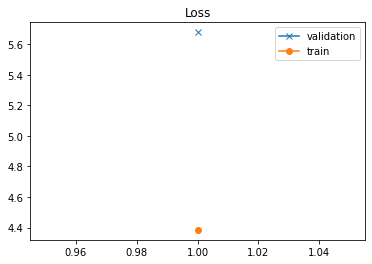

smallest val loss: (1, 5.6797333)
Current Lr:  0.0002699882

Time taken for this epoch: 213.55 secs

Epoch 2 Batch 0 Loss 3.9828
Epoch 2 Batch 2 Loss 4.1102
Epoch 2 Batch 4 Loss 4.1276
Epoch 2 Batch 6 Loss 4.1257
Epoch 2 Batch 8 Loss 4.1443
Epoch 2 Batch 10 Loss 4.1407
Epoch 2 Batch 12 Loss 4.1507
Epoch 2 Batch 14 Loss 4.1683
Epoch 2 Batch 16 Loss 4.1725
Epoch 2 Batch 18 Loss 4.1792
Epoch 2 Batch 20 Loss 4.1802
Epoch 2 Batch 22 Loss 4.1883
Epoch 2 Batch 24 Loss 4.1936
Epoch 2 Batch 26 Loss 4.2019
Epoch 2 Batch 28 Loss 4.2021
Epoch 2 Batch 30 Loss 4.2049
Epoch 2 Batch 32 Loss 4.2094
Epoch 2 Batch 34 Loss 4.2086
Epoch 2 Batch 36 Loss 4.2097
Epoch 2 Batch 38 Loss 4.2026
Epoch 2 Batch 40 Loss 4.2015
Epoch 2 Batch 42 Loss 4.2055
Epoch 2 Batch 44 Loss 4.2053
Epoch 2 Batch 46 Loss 4.2045
Epoch 2 Batch 48 Loss 4.2091
Epoch 2 Batch 50 Loss 4.2074
Epoch 2 Batch 52 Loss 4.2094
Epoch 2 Batch 54 Loss 4.2098
Epoch 2 Batch 56 Loss 4.2112
Epoch 2 Batch 58 Loss 4.2126
Epoch 2 Batch 60 Loss 4.2115
Epoch

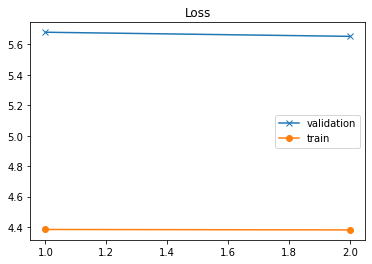

smallest val loss: (2, 5.652735)
Current Lr:  0.0002678639

Time taken for this epoch: 190.67 secs

Epoch 3 Batch 0 Loss 4.3368
Epoch 3 Batch 2 Loss 4.3000
Epoch 3 Batch 4 Loss 4.2615
Epoch 3 Batch 6 Loss 4.2878
Epoch 3 Batch 8 Loss 4.2942
Epoch 3 Batch 10 Loss 4.2893
Epoch 3 Batch 12 Loss 4.2867
Epoch 3 Batch 14 Loss 4.2785
Epoch 3 Batch 16 Loss 4.2560
Epoch 3 Batch 18 Loss 4.2489
Epoch 3 Batch 20 Loss 4.2590
Epoch 3 Batch 22 Loss 4.2529
Epoch 3 Batch 24 Loss 4.2487
Epoch 3 Batch 26 Loss 4.2442
Epoch 3 Batch 28 Loss 4.2448
Epoch 3 Batch 30 Loss 4.2510
Epoch 3 Batch 32 Loss 4.2444
Epoch 3 Batch 34 Loss 4.2449
Epoch 3 Batch 36 Loss 4.2396
Epoch 3 Batch 38 Loss 4.2439
Epoch 3 Batch 40 Loss 4.2459
Epoch 3 Batch 42 Loss 4.2434
Epoch 3 Batch 44 Loss 4.2473
Epoch 3 Batch 46 Loss 4.2485
Epoch 3 Batch 48 Loss 4.2426
Epoch 3 Batch 50 Loss 4.2423
Epoch 3 Batch 52 Loss 4.2449
Epoch 3 Batch 54 Loss 4.2417
Epoch 3 Batch 56 Loss 4.2420
Epoch 3 Batch 58 Loss 4.2412
Epoch 3 Batch 60 Loss 4.2391
Epoch 

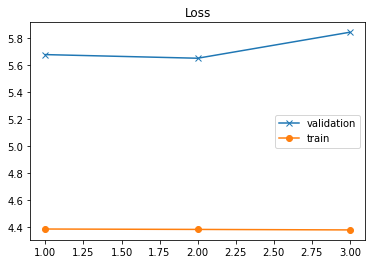

smallest val loss: (2, 5.652735)
Current Lr:  0.00026575633

Time taken for this epoch: 187.28 secs

Epoch 4 Batch 0 Loss 4.2586
Epoch 4 Batch 2 Loss 4.2464
Epoch 4 Batch 4 Loss 4.2399
Epoch 4 Batch 6 Loss 4.2403
Epoch 4 Batch 8 Loss 4.2160
Epoch 4 Batch 10 Loss 4.1965
Epoch 4 Batch 12 Loss 4.1937
Epoch 4 Batch 14 Loss 4.1850
Epoch 4 Batch 16 Loss 4.1921
Epoch 4 Batch 18 Loss 4.2007
Epoch 4 Batch 20 Loss 4.1983
Epoch 4 Batch 22 Loss 4.2076
Epoch 4 Batch 24 Loss 4.2084
Epoch 4 Batch 26 Loss 4.2135
Epoch 4 Batch 28 Loss 4.2179
Epoch 4 Batch 30 Loss 4.2263
Epoch 4 Batch 32 Loss 4.2282
Epoch 4 Batch 34 Loss 4.2237
Epoch 4 Batch 36 Loss 4.2258
Epoch 4 Batch 38 Loss 4.2256
Epoch 4 Batch 40 Loss 4.2253
Epoch 4 Batch 42 Loss 4.2292
Epoch 4 Batch 44 Loss 4.2279
Epoch 4 Batch 46 Loss 4.2266
Epoch 4 Batch 48 Loss 4.2258
Epoch 4 Batch 50 Loss 4.2273
Epoch 4 Batch 52 Loss 4.2261
Epoch 4 Batch 54 Loss 4.2206
Epoch 4 Batch 56 Loss 4.2244
Epoch 4 Batch 58 Loss 4.2268
Epoch 4 Batch 60 Loss 4.2293
Epoch

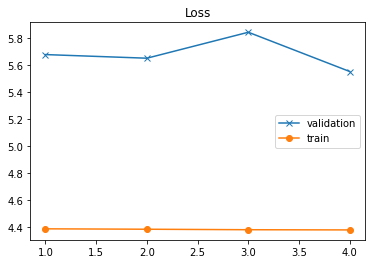

smallest val loss: (4, 5.553672)
Current Lr:  0.00026366537

Time taken for this epoch: 202.94 secs

Epoch 5 Batch 0 Loss 4.4072
Epoch 5 Batch 2 Loss 4.2699
Epoch 5 Batch 4 Loss 4.2515
Epoch 5 Batch 6 Loss 4.2289
Epoch 5 Batch 8 Loss 4.2226
Epoch 5 Batch 10 Loss 4.2265
Epoch 5 Batch 12 Loss 4.2274
Epoch 5 Batch 14 Loss 4.2295
Epoch 5 Batch 16 Loss 4.2174
Epoch 5 Batch 18 Loss 4.2227
Epoch 5 Batch 20 Loss 4.2188
Epoch 5 Batch 22 Loss 4.2215
Epoch 5 Batch 24 Loss 4.2162
Epoch 5 Batch 26 Loss 4.2222
Epoch 5 Batch 28 Loss 4.2184
Epoch 5 Batch 30 Loss 4.2199
Epoch 5 Batch 32 Loss 4.2196
Epoch 5 Batch 34 Loss 4.2220
Epoch 5 Batch 36 Loss 4.2198
Epoch 5 Batch 38 Loss 4.2167
Epoch 5 Batch 40 Loss 4.2199
Epoch 5 Batch 42 Loss 4.2238
Epoch 5 Batch 44 Loss 4.2201
Epoch 5 Batch 46 Loss 4.2185
Epoch 5 Batch 48 Loss 4.2161
Epoch 5 Batch 50 Loss 4.2173
Epoch 5 Batch 52 Loss 4.2179
Epoch 5 Batch 54 Loss 4.2173
Epoch 5 Batch 56 Loss 4.2192
Epoch 5 Batch 58 Loss 4.2240
Epoch 5 Batch 60 Loss 4.2266
Epoch

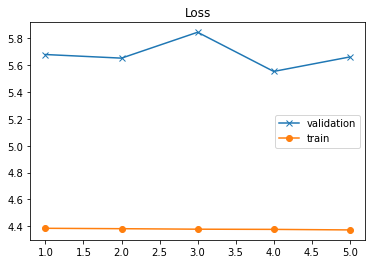

smallest val loss: (4, 5.553672)
Current Lr:  0.00026159085

Time taken for this epoch: 192.59 secs

Epoch 6 Batch 0 Loss 4.2936
Epoch 6 Batch 2 Loss 4.1581
Epoch 6 Batch 4 Loss 4.1618
Epoch 6 Batch 6 Loss 4.1788
Epoch 6 Batch 8 Loss 4.1946
Epoch 6 Batch 10 Loss 4.1874
Epoch 6 Batch 12 Loss 4.1963
Epoch 6 Batch 14 Loss 4.2012
Epoch 6 Batch 16 Loss 4.1931
Epoch 6 Batch 18 Loss 4.1883
Epoch 6 Batch 20 Loss 4.1852
Epoch 6 Batch 22 Loss 4.1893
Epoch 6 Batch 24 Loss 4.1964
Epoch 6 Batch 26 Loss 4.2020
Epoch 6 Batch 28 Loss 4.1981
Epoch 6 Batch 30 Loss 4.2001
Epoch 6 Batch 32 Loss 4.1962
Epoch 6 Batch 34 Loss 4.1991
Epoch 6 Batch 36 Loss 4.2054
Epoch 6 Batch 38 Loss 4.2062
Epoch 6 Batch 40 Loss 4.2106
Epoch 6 Batch 42 Loss 4.2185
Epoch 6 Batch 44 Loss 4.2227
Epoch 6 Batch 46 Loss 4.2202
Epoch 6 Batch 48 Loss 4.2210
Epoch 6 Batch 50 Loss 4.2245
Epoch 6 Batch 52 Loss 4.2236
Epoch 6 Batch 54 Loss 4.2256
Epoch 6 Batch 56 Loss 4.2295
Epoch 6 Batch 58 Loss 4.2298
Epoch 6 Batch 60 Loss 4.2291
Epoch

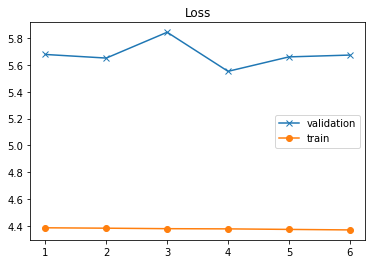

smallest val loss: (4, 5.553672)
Current Lr:  0.0002595326

Time taken for this epoch: 191.71 secs

Epoch 7 Batch 0 Loss 4.1396
Epoch 7 Batch 2 Loss 4.1913
Epoch 7 Batch 4 Loss 4.2122
Epoch 7 Batch 6 Loss 4.1967
Epoch 7 Batch 8 Loss 4.1981
Epoch 7 Batch 10 Loss 4.1866
Epoch 7 Batch 12 Loss 4.1935
Epoch 7 Batch 14 Loss 4.1927
Epoch 7 Batch 16 Loss 4.1894
Epoch 7 Batch 18 Loss 4.1948
Epoch 7 Batch 20 Loss 4.1932
Epoch 7 Batch 22 Loss 4.1965
Epoch 7 Batch 24 Loss 4.1980
Epoch 7 Batch 26 Loss 4.2049
Epoch 7 Batch 28 Loss 4.2092
Epoch 7 Batch 30 Loss 4.2102
Epoch 7 Batch 32 Loss 4.2123
Epoch 7 Batch 34 Loss 4.2095
Epoch 7 Batch 36 Loss 4.2065
Epoch 7 Batch 38 Loss 4.2049
Epoch 7 Batch 40 Loss 4.2038
Epoch 7 Batch 42 Loss 4.2094
Epoch 7 Batch 44 Loss 4.2103
Epoch 7 Batch 46 Loss 4.2116
Epoch 7 Batch 48 Loss 4.2121
Epoch 7 Batch 50 Loss 4.2104
Epoch 7 Batch 52 Loss 4.2125
Epoch 7 Batch 54 Loss 4.2173
Epoch 7 Batch 56 Loss 4.2208
Epoch 7 Batch 58 Loss 4.2206
Epoch 7 Batch 60 Loss 4.2238
Epoch 

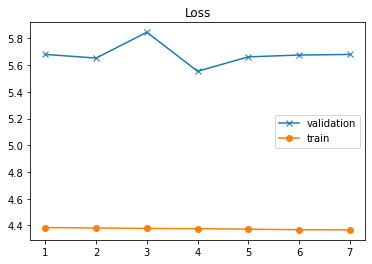

smallest val loss: (4, 5.553672)
Current Lr:  0.0002574906

Time taken for this epoch: 191.46 secs

Epoch 8 Batch 0 Loss 4.3299
Epoch 8 Batch 2 Loss 4.2480
Epoch 8 Batch 4 Loss 4.2271
Epoch 8 Batch 6 Loss 4.2113
Epoch 8 Batch 8 Loss 4.2142
Epoch 8 Batch 10 Loss 4.2369
Epoch 8 Batch 12 Loss 4.2372
Epoch 8 Batch 14 Loss 4.2217
Epoch 8 Batch 16 Loss 4.2172
Epoch 8 Batch 18 Loss 4.2238
Epoch 8 Batch 20 Loss 4.2241
Epoch 8 Batch 22 Loss 4.2214
Epoch 8 Batch 24 Loss 4.2151
Epoch 8 Batch 26 Loss 4.2214
Epoch 8 Batch 28 Loss 4.2258
Epoch 8 Batch 30 Loss 4.2291
Epoch 8 Batch 32 Loss 4.2252
Epoch 8 Batch 34 Loss 4.2230
Epoch 8 Batch 36 Loss 4.2310
Epoch 8 Batch 38 Loss 4.2279
Epoch 8 Batch 40 Loss 4.2275
Epoch 8 Batch 42 Loss 4.2313
Epoch 8 Batch 44 Loss 4.2380
Epoch 8 Batch 46 Loss 4.2392
Epoch 8 Batch 48 Loss 4.2414
Epoch 8 Batch 50 Loss 4.2441
Epoch 8 Batch 52 Loss 4.2430
Epoch 8 Batch 54 Loss 4.2440
Epoch 8 Batch 56 Loss 4.2423
Epoch 8 Batch 58 Loss 4.2438
Epoch 8 Batch 60 Loss 4.2443
Epoch 

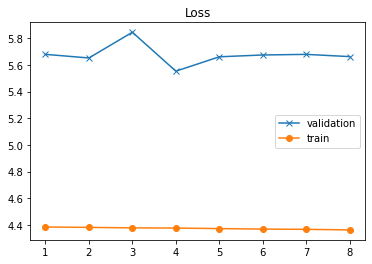

smallest val loss: (4, 5.553672)
Current Lr:  0.00025546466

Time taken for this epoch: 191.47 secs

Epoch 9 Batch 0 Loss 4.3242
Epoch 9 Batch 2 Loss 4.1954
Epoch 9 Batch 4 Loss 4.1762
Epoch 9 Batch 6 Loss 4.1917
Epoch 9 Batch 8 Loss 4.1858
Epoch 9 Batch 10 Loss 4.1836
Epoch 9 Batch 12 Loss 4.2195
Epoch 9 Batch 14 Loss 4.2203
Epoch 9 Batch 16 Loss 4.2099
Epoch 9 Batch 18 Loss 4.2239
Epoch 9 Batch 20 Loss 4.2242
Epoch 9 Batch 22 Loss 4.2290
Epoch 9 Batch 24 Loss 4.2309
Epoch 9 Batch 26 Loss 4.2277
Epoch 9 Batch 28 Loss 4.2270
Epoch 9 Batch 30 Loss 4.2257
Epoch 9 Batch 32 Loss 4.2278
Epoch 9 Batch 34 Loss 4.2262
Epoch 9 Batch 36 Loss 4.2262
Epoch 9 Batch 38 Loss 4.2279
Epoch 9 Batch 40 Loss 4.2311
Epoch 9 Batch 42 Loss 4.2279
Epoch 9 Batch 44 Loss 4.2293
Epoch 9 Batch 46 Loss 4.2278
Epoch 9 Batch 48 Loss 4.2320
Epoch 9 Batch 50 Loss 4.2337
Epoch 9 Batch 52 Loss 4.2328
Epoch 9 Batch 54 Loss 4.2333
Epoch 9 Batch 56 Loss 4.2379
Epoch 9 Batch 58 Loss 4.2386
Epoch 9 Batch 60 Loss 4.2395
Epoch

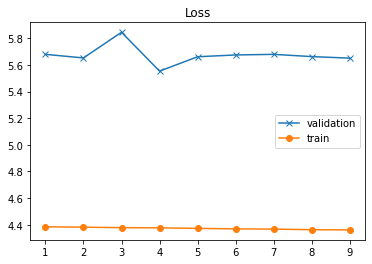

smallest val loss: (4, 5.553672)
Current Lr:  0.0002534546

Time taken for this epoch: 191.77 secs

Epoch 10 Batch 0 Loss 4.1902
Epoch 10 Batch 2 Loss 4.2244
Epoch 10 Batch 4 Loss 4.1665
Epoch 10 Batch 6 Loss 4.1736
Epoch 10 Batch 8 Loss 4.1738
Epoch 10 Batch 10 Loss 4.1991
Epoch 10 Batch 12 Loss 4.2026
Epoch 10 Batch 14 Loss 4.1997
Epoch 10 Batch 16 Loss 4.2016
Epoch 10 Batch 18 Loss 4.2055
Epoch 10 Batch 20 Loss 4.2092
Epoch 10 Batch 22 Loss 4.2124
Epoch 10 Batch 24 Loss 4.2077
Epoch 10 Batch 26 Loss 4.2144
Epoch 10 Batch 28 Loss 4.2155
Epoch 10 Batch 30 Loss 4.2141
Epoch 10 Batch 32 Loss 4.2169
Epoch 10 Batch 34 Loss 4.2157
Epoch 10 Batch 36 Loss 4.2130
Epoch 10 Batch 38 Loss 4.2150
Epoch 10 Batch 40 Loss 4.2130
Epoch 10 Batch 42 Loss 4.2106
Epoch 10 Batch 44 Loss 4.2130
Epoch 10 Batch 46 Loss 4.2204
Epoch 10 Batch 48 Loss 4.2178
Epoch 10 Batch 50 Loss 4.2229
Epoch 10 Batch 52 Loss 4.2213
Epoch 10 Batch 54 Loss 4.2200
Epoch 10 Batch 56 Loss 4.2207
Epoch 10 Batch 58 Loss 4.2191
Epoch

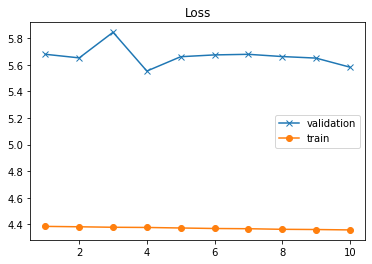

smallest val loss: (4, 5.553672)
Current Lr:  0.00025146047

Time taken for this epoch: 194.10 secs

Epoch 11 Batch 0 Loss 4.1852
Epoch 11 Batch 2 Loss 4.1776
Epoch 11 Batch 4 Loss 4.1548
Epoch 11 Batch 6 Loss 4.1856
Epoch 11 Batch 8 Loss 4.1979
Epoch 11 Batch 10 Loss 4.2181
Epoch 11 Batch 12 Loss 4.2130
Epoch 11 Batch 14 Loss 4.2285
Epoch 11 Batch 16 Loss 4.2264
Epoch 11 Batch 18 Loss 4.2171
Epoch 11 Batch 20 Loss 4.2234
Epoch 11 Batch 22 Loss 4.2204
Epoch 11 Batch 24 Loss 4.2203
Epoch 11 Batch 26 Loss 4.2191
Epoch 11 Batch 28 Loss 4.2125
Epoch 11 Batch 30 Loss 4.2052
Epoch 11 Batch 32 Loss 4.2078
Epoch 11 Batch 34 Loss 4.2097
Epoch 11 Batch 36 Loss 4.2094
Epoch 11 Batch 38 Loss 4.2055
Epoch 11 Batch 40 Loss 4.2070
Epoch 11 Batch 42 Loss 4.2077
Epoch 11 Batch 44 Loss 4.2086
Epoch 11 Batch 46 Loss 4.2055
Epoch 11 Batch 48 Loss 4.2091
Epoch 11 Batch 50 Loss 4.2113
Epoch 11 Batch 52 Loss 4.2155
Epoch 11 Batch 54 Loss 4.2195
Epoch 11 Batch 56 Loss 4.2160
Epoch 11 Batch 58 Loss 4.2167
Epoc

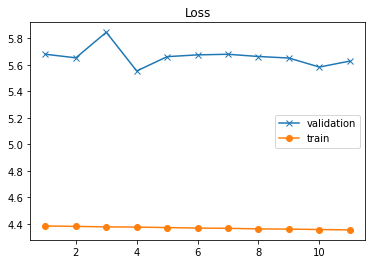

smallest val loss: (4, 5.553672)
Current Lr:  0.00024948196

Time taken for this epoch: 195.90 secs

Epoch 12 Batch 0 Loss 4.2507
Epoch 12 Batch 2 Loss 4.1947
Epoch 12 Batch 4 Loss 4.2362
Epoch 12 Batch 6 Loss 4.1989
Epoch 12 Batch 8 Loss 4.2030
Epoch 12 Batch 10 Loss 4.2147
Epoch 12 Batch 12 Loss 4.2133
Epoch 12 Batch 14 Loss 4.2221
Epoch 12 Batch 16 Loss 4.2341
Epoch 12 Batch 18 Loss 4.2170
Epoch 12 Batch 20 Loss 4.2116
Epoch 12 Batch 22 Loss 4.2035
Epoch 12 Batch 24 Loss 4.2024
Epoch 12 Batch 26 Loss 4.2039
Epoch 12 Batch 28 Loss 4.2035
Epoch 12 Batch 30 Loss 4.2045
Epoch 12 Batch 32 Loss 4.2095
Epoch 12 Batch 34 Loss 4.2041
Epoch 12 Batch 36 Loss 4.2075
Epoch 12 Batch 38 Loss 4.2052
Epoch 12 Batch 40 Loss 4.2068
Epoch 12 Batch 42 Loss 4.2063
Epoch 12 Batch 44 Loss 4.2130
Epoch 12 Batch 46 Loss 4.2180
Epoch 12 Batch 48 Loss 4.2171
Epoch 12 Batch 50 Loss 4.2178
Epoch 12 Batch 52 Loss 4.2171
Epoch 12 Batch 54 Loss 4.2210
Epoch 12 Batch 56 Loss 4.2257
Epoch 12 Batch 58 Loss 4.2267
Epoc

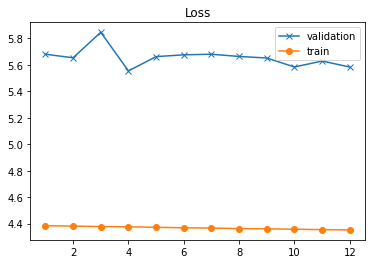

smallest val loss: (4, 5.553672)
Current Lr:  0.000247519

Time taken for this epoch: 196.12 secs

Epoch 13 Batch 0 Loss 4.2581
Epoch 13 Batch 2 Loss 4.1976
Epoch 13 Batch 4 Loss 4.2745
Epoch 13 Batch 6 Loss 4.2097
Epoch 13 Batch 8 Loss 4.1739
Epoch 13 Batch 10 Loss 4.1809
Epoch 13 Batch 12 Loss 4.1809
Epoch 13 Batch 14 Loss 4.1873
Epoch 13 Batch 16 Loss 4.2021
Epoch 13 Batch 18 Loss 4.2074
Epoch 13 Batch 20 Loss 4.2172
Epoch 13 Batch 22 Loss 4.2114
Epoch 13 Batch 24 Loss 4.2126
Epoch 13 Batch 26 Loss 4.2090
Epoch 13 Batch 28 Loss 4.2123
Epoch 13 Batch 30 Loss 4.2100
Epoch 13 Batch 32 Loss 4.2080
Epoch 13 Batch 34 Loss 4.2054
Epoch 13 Batch 36 Loss 4.2112
Epoch 13 Batch 38 Loss 4.2138
Epoch 13 Batch 40 Loss 4.2134
Epoch 13 Batch 42 Loss 4.2138
Epoch 13 Batch 44 Loss 4.2150
Epoch 13 Batch 46 Loss 4.2090
Epoch 13 Batch 48 Loss 4.2181
Epoch 13 Batch 50 Loss 4.2242
Epoch 13 Batch 52 Loss 4.2231
Epoch 13 Batch 54 Loss 4.2284
Epoch 13 Batch 56 Loss 4.2303
Epoch 13 Batch 58 Loss 4.2269
Epoch 

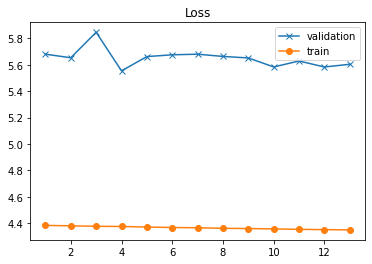

smallest val loss: (4, 5.553672)
Current Lr:  0.00024557151

Time taken for this epoch: 196.10 secs

Epoch 14 Batch 0 Loss 4.2729
Epoch 14 Batch 2 Loss 4.2192
Epoch 14 Batch 4 Loss 4.2507
Epoch 14 Batch 6 Loss 4.2622
Epoch 14 Batch 8 Loss 4.2400
Epoch 14 Batch 10 Loss 4.2435
Epoch 14 Batch 12 Loss 4.2152
Epoch 14 Batch 14 Loss 4.2073
Epoch 14 Batch 16 Loss 4.2075
Epoch 14 Batch 18 Loss 4.1960
Epoch 14 Batch 20 Loss 4.2100
Epoch 14 Batch 22 Loss 4.2130
Epoch 14 Batch 24 Loss 4.2175
Epoch 14 Batch 26 Loss 4.2193
Epoch 14 Batch 28 Loss 4.2116
Epoch 14 Batch 30 Loss 4.2243
Epoch 14 Batch 32 Loss 4.2165
Epoch 14 Batch 34 Loss 4.2183
Epoch 14 Batch 36 Loss 4.2228
Epoch 14 Batch 38 Loss 4.2177
Epoch 14 Batch 40 Loss 4.2180
Epoch 14 Batch 42 Loss 4.2171
Epoch 14 Batch 44 Loss 4.2167
Epoch 14 Batch 46 Loss 4.2237
Epoch 14 Batch 48 Loss 4.2203
Epoch 14 Batch 50 Loss 4.2229
Epoch 14 Batch 52 Loss 4.2245
Epoch 14 Batch 54 Loss 4.2291
Epoch 14 Batch 56 Loss 4.2251
Epoch 14 Batch 58 Loss 4.2227
Epoc

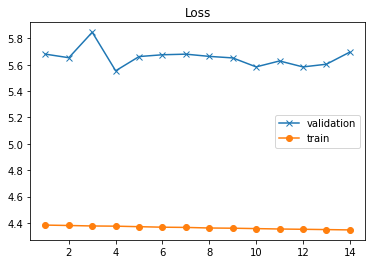

smallest val loss: (4, 5.553672)
Current Lr:  0.00024363934

Time taken for this epoch: 194.58 secs

Epoch 15 Batch 0 Loss 4.2490
Epoch 15 Batch 2 Loss 4.2448
Epoch 15 Batch 4 Loss 4.2344
Epoch 15 Batch 6 Loss 4.2537
Epoch 15 Batch 8 Loss 4.2312
Epoch 15 Batch 10 Loss 4.2272
Epoch 15 Batch 12 Loss 4.2241
Epoch 15 Batch 14 Loss 4.2170
Epoch 15 Batch 16 Loss 4.2100
Epoch 15 Batch 18 Loss 4.2108
Epoch 15 Batch 20 Loss 4.2128
Epoch 15 Batch 22 Loss 4.2210
Epoch 15 Batch 24 Loss 4.2157
Epoch 15 Batch 26 Loss 4.2161
Epoch 15 Batch 28 Loss 4.2132
Epoch 15 Batch 30 Loss 4.2179
Epoch 15 Batch 32 Loss 4.2176
Epoch 15 Batch 34 Loss 4.2130
Epoch 15 Batch 36 Loss 4.2102
Epoch 15 Batch 38 Loss 4.2104
Epoch 15 Batch 40 Loss 4.2080
Epoch 15 Batch 42 Loss 4.2078
Epoch 15 Batch 44 Loss 4.2089
Epoch 15 Batch 46 Loss 4.2096
Epoch 15 Batch 48 Loss 4.2107
Epoch 15 Batch 50 Loss 4.2117
Epoch 15 Batch 52 Loss 4.2164
Epoch 15 Batch 54 Loss 4.2182
Epoch 15 Batch 56 Loss 4.2206
Epoch 15 Batch 58 Loss 4.2230
Epoc

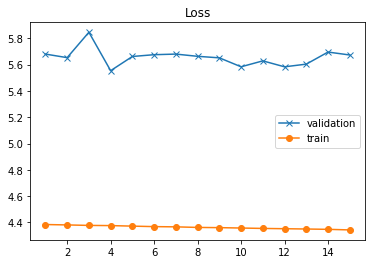

smallest val loss: (4, 5.553672)
Current Lr:  0.00024172236

Time taken for this epoch: 191.44 secs

Epoch 16 Batch 0 Loss 4.1223
Epoch 16 Batch 2 Loss 4.1431
Epoch 16 Batch 4 Loss 4.1556
Epoch 16 Batch 6 Loss 4.1729
Epoch 16 Batch 8 Loss 4.2021
Epoch 16 Batch 10 Loss 4.1977
Epoch 16 Batch 12 Loss 4.1837
Epoch 16 Batch 14 Loss 4.1972
Epoch 16 Batch 16 Loss 4.1887
Epoch 16 Batch 18 Loss 4.1721
Epoch 16 Batch 20 Loss 4.1897
Epoch 16 Batch 22 Loss 4.1974
Epoch 16 Batch 24 Loss 4.1981
Epoch 16 Batch 26 Loss 4.2079
Epoch 16 Batch 28 Loss 4.2055
Epoch 16 Batch 30 Loss 4.2011
Epoch 16 Batch 32 Loss 4.2029
Epoch 16 Batch 34 Loss 4.1993
Epoch 16 Batch 36 Loss 4.1971
Epoch 16 Batch 38 Loss 4.1976
Epoch 16 Batch 40 Loss 4.1963
Epoch 16 Batch 42 Loss 4.1957
Epoch 16 Batch 44 Loss 4.1922
Epoch 16 Batch 46 Loss 4.1944
Epoch 16 Batch 48 Loss 4.1950
Epoch 16 Batch 50 Loss 4.1992
Epoch 16 Batch 52 Loss 4.1991
Epoch 16 Batch 54 Loss 4.2017
Epoch 16 Batch 56 Loss 4.1997
Epoch 16 Batch 58 Loss 4.2072
Epoc

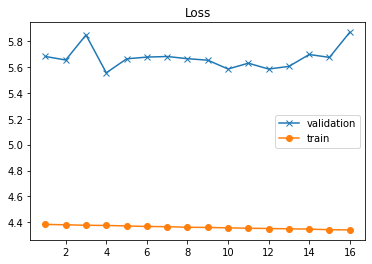

smallest val loss: (4, 5.553672)
Current Lr:  0.0002398205

Time taken for this epoch: 190.97 secs

Epoch 17 Batch 0 Loss 4.2411
Epoch 17 Batch 2 Loss 4.2148
Epoch 17 Batch 4 Loss 4.1947
Epoch 17 Batch 6 Loss 4.1773
Epoch 17 Batch 8 Loss 4.1648
Epoch 17 Batch 10 Loss 4.1660
Epoch 17 Batch 12 Loss 4.1644
Epoch 17 Batch 14 Loss 4.1755
Epoch 17 Batch 16 Loss 4.1870
Epoch 17 Batch 18 Loss 4.1867
Epoch 17 Batch 20 Loss 4.1933
Epoch 17 Batch 22 Loss 4.1951
Epoch 17 Batch 24 Loss 4.1923
Epoch 17 Batch 26 Loss 4.1927
Epoch 17 Batch 28 Loss 4.1901
Epoch 17 Batch 30 Loss 4.1998
Epoch 17 Batch 32 Loss 4.2041
Epoch 17 Batch 34 Loss 4.2083
Epoch 17 Batch 36 Loss 4.2082
Epoch 17 Batch 38 Loss 4.2078
Epoch 17 Batch 40 Loss 4.2144
Epoch 17 Batch 42 Loss 4.2140
Epoch 17 Batch 44 Loss 4.2171
Epoch 17 Batch 46 Loss 4.2181
Epoch 17 Batch 48 Loss 4.2201
Epoch 17 Batch 50 Loss 4.2225
Epoch 17 Batch 52 Loss 4.2233
Epoch 17 Batch 54 Loss 4.2295
Epoch 17 Batch 56 Loss 4.2277
Epoch 17 Batch 58 Loss 4.2313
Epoch

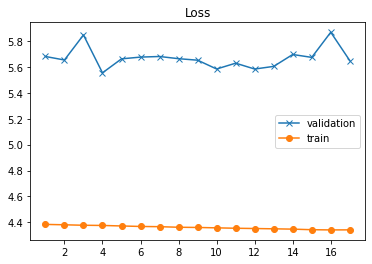

smallest val loss: (4, 5.553672)
Current Lr:  0.00023793358

Time taken for this epoch: 193.67 secs

Epoch 18 Batch 0 Loss 4.3397
Epoch 18 Batch 2 Loss 4.2108
Epoch 18 Batch 4 Loss 4.1915
Epoch 18 Batch 6 Loss 4.2258
Epoch 18 Batch 8 Loss 4.1954
Epoch 18 Batch 10 Loss 4.1869
Epoch 18 Batch 12 Loss 4.1709
Epoch 18 Batch 14 Loss 4.1760
Epoch 18 Batch 16 Loss 4.1822
Epoch 18 Batch 18 Loss 4.1937
Epoch 18 Batch 20 Loss 4.1885
Epoch 18 Batch 22 Loss 4.1856
Epoch 18 Batch 24 Loss 4.1878
Epoch 18 Batch 26 Loss 4.1850
Epoch 18 Batch 28 Loss 4.1862
Epoch 18 Batch 30 Loss 4.1920
Epoch 18 Batch 32 Loss 4.1983
Epoch 18 Batch 34 Loss 4.2044
Epoch 18 Batch 36 Loss 4.2098
Epoch 18 Batch 38 Loss 4.2079
Epoch 18 Batch 40 Loss 4.2099
Epoch 18 Batch 42 Loss 4.2127
Epoch 18 Batch 44 Loss 4.2129
Epoch 18 Batch 46 Loss 4.2175
Epoch 18 Batch 48 Loss 4.2184
Epoch 18 Batch 50 Loss 4.2180
Epoch 18 Batch 52 Loss 4.2147
Epoch 18 Batch 54 Loss 4.2154
Epoch 18 Batch 56 Loss 4.2180
Epoch 18 Batch 58 Loss 4.2196
Epoc

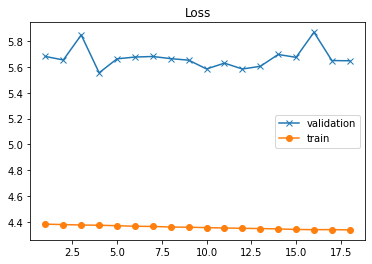

smallest val loss: (4, 5.553672)
Current Lr:  0.00023606149

Time taken for this epoch: 194.65 secs

Epoch 19 Batch 0 Loss 4.2926
Epoch 19 Batch 2 Loss 4.2294
Epoch 19 Batch 4 Loss 4.2363
Epoch 19 Batch 6 Loss 4.2349
Epoch 19 Batch 8 Loss 4.2140
Epoch 19 Batch 10 Loss 4.2045
Epoch 19 Batch 12 Loss 4.1936
Epoch 19 Batch 14 Loss 4.1864
Epoch 19 Batch 16 Loss 4.1823
Epoch 19 Batch 18 Loss 4.1897
Epoch 19 Batch 20 Loss 4.1908
Epoch 19 Batch 22 Loss 4.1954
Epoch 19 Batch 24 Loss 4.1961
Epoch 19 Batch 26 Loss 4.1949
Epoch 19 Batch 28 Loss 4.1994
Epoch 19 Batch 30 Loss 4.2021
Epoch 19 Batch 32 Loss 4.2104
Epoch 19 Batch 34 Loss 4.2142
Epoch 19 Batch 36 Loss 4.2173
Epoch 19 Batch 38 Loss 4.2220
Epoch 19 Batch 40 Loss 4.2193
Epoch 19 Batch 42 Loss 4.2211
Epoch 19 Batch 44 Loss 4.2228
Epoch 19 Batch 46 Loss 4.2217
Epoch 19 Batch 48 Loss 4.2219
Epoch 19 Batch 50 Loss 4.2229
Epoch 19 Batch 52 Loss 4.2248
Epoch 19 Batch 54 Loss 4.2244
Epoch 19 Batch 56 Loss 4.2249
Epoch 19 Batch 58 Loss 4.2255
Epoc

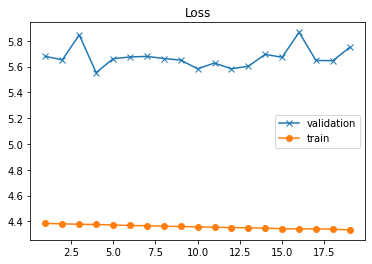

smallest val loss: (4, 5.553672)
Current Lr:  0.00023420416

Time taken for this epoch: 192.40 secs

Epoch 20 Batch 0 Loss 4.0904
Epoch 20 Batch 2 Loss 4.2188
Epoch 20 Batch 4 Loss 4.1794
Epoch 20 Batch 6 Loss 4.2359
Epoch 20 Batch 8 Loss 4.2266
Epoch 20 Batch 10 Loss 4.2308
Epoch 20 Batch 12 Loss 4.2222
Epoch 20 Batch 14 Loss 4.2334
Epoch 20 Batch 16 Loss 4.2347
Epoch 20 Batch 18 Loss 4.2280
Epoch 20 Batch 20 Loss 4.2259
Epoch 20 Batch 22 Loss 4.2190
Epoch 20 Batch 24 Loss 4.2244
Epoch 20 Batch 26 Loss 4.2238
Epoch 20 Batch 28 Loss 4.2175
Epoch 20 Batch 30 Loss 4.2146
Epoch 20 Batch 32 Loss 4.2130
Epoch 20 Batch 34 Loss 4.2081
Epoch 20 Batch 36 Loss 4.2031
Epoch 20 Batch 38 Loss 4.2059
Epoch 20 Batch 40 Loss 4.2047
Epoch 20 Batch 42 Loss 4.2036
Epoch 20 Batch 44 Loss 4.2041
Epoch 20 Batch 46 Loss 4.2024
Epoch 20 Batch 48 Loss 4.2044
Epoch 20 Batch 50 Loss 4.2060
Epoch 20 Batch 52 Loss 4.2092
Epoch 20 Batch 54 Loss 4.2120
Epoch 20 Batch 56 Loss 4.2129
Epoch 20 Batch 58 Loss 4.2153
Epoc

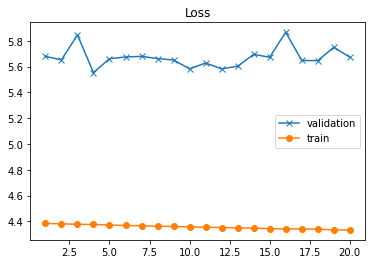

smallest val loss: (4, 5.553672)
Current Lr:  0.00023236142

Time taken for this epoch: 192.26 secs

Epoch 21 Batch 0 Loss 4.1888
Epoch 21 Batch 2 Loss 4.1387
Epoch 21 Batch 4 Loss 4.1274
Epoch 21 Batch 6 Loss 4.1702
Epoch 21 Batch 8 Loss 4.1687
Epoch 21 Batch 10 Loss 4.1920
Epoch 21 Batch 12 Loss 4.2017
Epoch 21 Batch 14 Loss 4.2157
Epoch 21 Batch 16 Loss 4.2128
Epoch 21 Batch 18 Loss 4.2166
Epoch 21 Batch 20 Loss 4.2090
Epoch 21 Batch 22 Loss 4.2161
Epoch 21 Batch 24 Loss 4.2143
Epoch 21 Batch 26 Loss 4.2114
Epoch 21 Batch 28 Loss 4.2119
Epoch 21 Batch 30 Loss 4.2077
Epoch 21 Batch 32 Loss 4.2045
Epoch 21 Batch 34 Loss 4.2075
Epoch 21 Batch 36 Loss 4.2075
Epoch 21 Batch 38 Loss 4.2187
Epoch 21 Batch 40 Loss 4.2163
Epoch 21 Batch 42 Loss 4.2159
Epoch 21 Batch 44 Loss 4.2172
Epoch 21 Batch 46 Loss 4.2172
Epoch 21 Batch 48 Loss 4.2159
Epoch 21 Batch 50 Loss 4.2183
Epoch 21 Batch 52 Loss 4.2239
Epoch 21 Batch 54 Loss 4.2220
Epoch 21 Batch 56 Loss 4.2261
Epoch 21 Batch 58 Loss 4.2302
Epoc

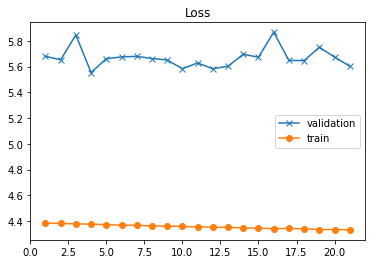

smallest val loss: (4, 5.553672)
Current Lr:  0.0002305332

Time taken for this epoch: 199.64 secs

Epoch 22 Batch 0 Loss 4.2590
Epoch 22 Batch 2 Loss 4.1692
Epoch 22 Batch 4 Loss 4.2360
Epoch 22 Batch 6 Loss 4.2139
Epoch 22 Batch 8 Loss 4.2242
Epoch 22 Batch 10 Loss 4.2052
Epoch 22 Batch 12 Loss 4.2057
Epoch 22 Batch 14 Loss 4.2100
Epoch 22 Batch 16 Loss 4.2063
Epoch 22 Batch 18 Loss 4.2137
Epoch 22 Batch 20 Loss 4.2130
Epoch 22 Batch 22 Loss 4.2167
Epoch 22 Batch 24 Loss 4.2197
Epoch 22 Batch 26 Loss 4.2231
Epoch 22 Batch 28 Loss 4.2307
Epoch 22 Batch 30 Loss 4.2277
Epoch 22 Batch 32 Loss 4.2201
Epoch 22 Batch 34 Loss 4.2204
Epoch 22 Batch 36 Loss 4.2167
Epoch 22 Batch 38 Loss 4.2182
Epoch 22 Batch 40 Loss 4.2155
Epoch 22 Batch 42 Loss 4.2170
Epoch 22 Batch 44 Loss 4.2197
Epoch 22 Batch 46 Loss 4.2153
Epoch 22 Batch 48 Loss 4.2105
Epoch 22 Batch 50 Loss 4.2107
Epoch 22 Batch 52 Loss 4.2121
Epoch 22 Batch 54 Loss 4.2119
Epoch 22 Batch 56 Loss 4.2119
Epoch 22 Batch 58 Loss 4.2150
Epoch

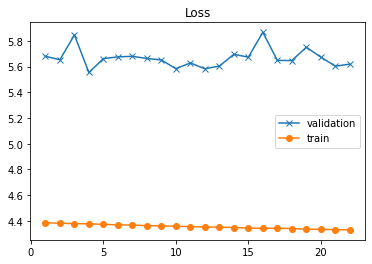

smallest val loss: (4, 5.553672)
Current Lr:  0.00022871933

Time taken for this epoch: 195.27 secs

Epoch 23 Batch 0 Loss 4.1634
Epoch 23 Batch 2 Loss 4.1570
Epoch 23 Batch 4 Loss 4.1328
Epoch 23 Batch 6 Loss 4.1271
Epoch 23 Batch 8 Loss 4.1128
Epoch 23 Batch 10 Loss 4.0964
Epoch 23 Batch 12 Loss 4.1067
Epoch 23 Batch 14 Loss 4.1286
Epoch 23 Batch 16 Loss 4.1444
Epoch 23 Batch 18 Loss 4.1607
Epoch 23 Batch 20 Loss 4.1657
Epoch 23 Batch 22 Loss 4.1706
Epoch 23 Batch 24 Loss 4.1782
Epoch 23 Batch 26 Loss 4.1705
Epoch 23 Batch 28 Loss 4.1694
Epoch 23 Batch 30 Loss 4.1732
Epoch 23 Batch 32 Loss 4.1648
Epoch 23 Batch 34 Loss 4.1695
Epoch 23 Batch 36 Loss 4.1770
Epoch 23 Batch 38 Loss 4.1828
Epoch 23 Batch 40 Loss 4.1841
Epoch 23 Batch 42 Loss 4.1834
Epoch 23 Batch 44 Loss 4.1877
Epoch 23 Batch 46 Loss 4.1869
Epoch 23 Batch 48 Loss 4.1950
Epoch 23 Batch 50 Loss 4.1954
Epoch 23 Batch 52 Loss 4.1988
Epoch 23 Batch 54 Loss 4.2011
Epoch 23 Batch 56 Loss 4.1979
Epoch 23 Batch 58 Loss 4.1986
Epoc

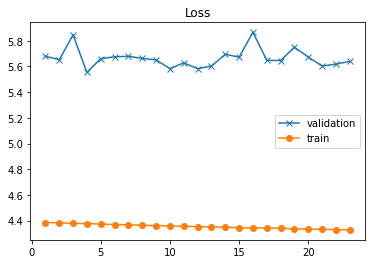

smallest val loss: (4, 5.553672)
Current Lr:  0.00022691977

Time taken for this epoch: 196.12 secs

Epoch 24 Batch 0 Loss 4.2220
Epoch 24 Batch 2 Loss 4.1919
Epoch 24 Batch 4 Loss 4.2245
Epoch 24 Batch 6 Loss 4.2203
Epoch 24 Batch 8 Loss 4.2159
Epoch 24 Batch 10 Loss 4.2148
Epoch 24 Batch 12 Loss 4.2108
Epoch 24 Batch 14 Loss 4.2071
Epoch 24 Batch 16 Loss 4.2125
Epoch 24 Batch 18 Loss 4.2052
Epoch 24 Batch 20 Loss 4.2053
Epoch 24 Batch 22 Loss 4.2119
Epoch 24 Batch 24 Loss 4.2049
Epoch 24 Batch 26 Loss 4.2028
Epoch 24 Batch 28 Loss 4.2154
Epoch 24 Batch 30 Loss 4.2201
Epoch 24 Batch 32 Loss 4.2211
Epoch 24 Batch 34 Loss 4.2253
Epoch 24 Batch 36 Loss 4.2211
Epoch 24 Batch 38 Loss 4.2254
Epoch 24 Batch 40 Loss 4.2262
Epoch 24 Batch 42 Loss 4.2260
Epoch 24 Batch 44 Loss 4.2278
Epoch 24 Batch 46 Loss 4.2234
Epoch 24 Batch 48 Loss 4.2212
Epoch 24 Batch 50 Loss 4.2246
Epoch 24 Batch 52 Loss 4.2277
Epoch 24 Batch 54 Loss 4.2221
Epoch 24 Batch 56 Loss 4.2220
Epoch 24 Batch 58 Loss 4.2220
Epoc

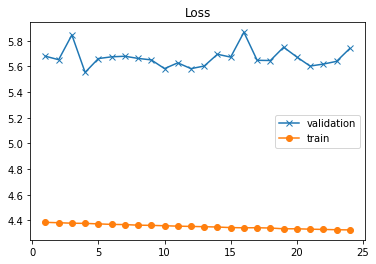

smallest val loss: (4, 5.553672)
Current Lr:  0.00022513435

Time taken for this epoch: 191.92 secs

Epoch 25 Batch 0 Loss 4.1788
Epoch 25 Batch 2 Loss 4.2370
Epoch 25 Batch 4 Loss 4.1919
Epoch 25 Batch 6 Loss 4.1999
Epoch 25 Batch 8 Loss 4.2223
Epoch 25 Batch 10 Loss 4.2045
Epoch 25 Batch 12 Loss 4.2156
Epoch 25 Batch 14 Loss 4.2207
Epoch 25 Batch 16 Loss 4.2108
Epoch 25 Batch 18 Loss 4.2060
Epoch 25 Batch 20 Loss 4.2098
Epoch 25 Batch 22 Loss 4.2074
Epoch 25 Batch 24 Loss 4.2041
Epoch 25 Batch 26 Loss 4.1977
Epoch 25 Batch 28 Loss 4.2020
Epoch 25 Batch 30 Loss 4.1958
Epoch 25 Batch 32 Loss 4.2041
Epoch 25 Batch 34 Loss 4.2137
Epoch 25 Batch 36 Loss 4.2110
Epoch 25 Batch 38 Loss 4.2094
Epoch 25 Batch 40 Loss 4.2055
Epoch 25 Batch 42 Loss 4.2121
Epoch 25 Batch 44 Loss 4.2139
Epoch 25 Batch 46 Loss 4.2136
Epoch 25 Batch 48 Loss 4.2099
Epoch 25 Batch 50 Loss 4.2085
Epoch 25 Batch 52 Loss 4.2100
Epoch 25 Batch 54 Loss 4.2103
Epoch 25 Batch 56 Loss 4.2112
Epoch 25 Batch 58 Loss 4.2140
Epoc

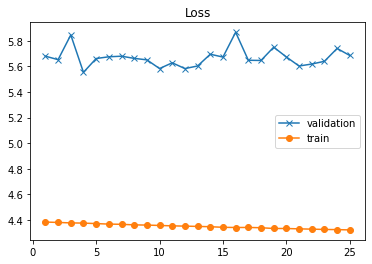

smallest val loss: (4, 5.553672)
Current Lr:  0.00022336298

Time taken for this epoch: 192.78 secs

Epoch 26 Batch 0 Loss 4.1580
Epoch 26 Batch 2 Loss 4.1985
Epoch 26 Batch 4 Loss 4.1851
Epoch 26 Batch 6 Loss 4.1797
Epoch 26 Batch 8 Loss 4.1705
Epoch 26 Batch 10 Loss 4.1753
Epoch 26 Batch 12 Loss 4.1712
Epoch 26 Batch 14 Loss 4.1881
Epoch 26 Batch 16 Loss 4.1911
Epoch 26 Batch 18 Loss 4.2030
Epoch 26 Batch 20 Loss 4.1960
Epoch 26 Batch 22 Loss 4.1911
Epoch 26 Batch 24 Loss 4.1887
Epoch 26 Batch 26 Loss 4.1932
Epoch 26 Batch 28 Loss 4.1957
Epoch 26 Batch 30 Loss 4.1962
Epoch 26 Batch 32 Loss 4.1896
Epoch 26 Batch 34 Loss 4.1940
Epoch 26 Batch 36 Loss 4.1913
Epoch 26 Batch 38 Loss 4.1880
Epoch 26 Batch 40 Loss 4.1852
Epoch 26 Batch 42 Loss 4.1861
Epoch 26 Batch 44 Loss 4.1907
Epoch 26 Batch 46 Loss 4.1893
Epoch 26 Batch 48 Loss 4.1944
Epoch 26 Batch 50 Loss 4.1945
Epoch 26 Batch 52 Loss 4.1959
Epoch 26 Batch 54 Loss 4.1998
Epoch 26 Batch 56 Loss 4.2039
Epoch 26 Batch 58 Loss 4.2012
Epoc

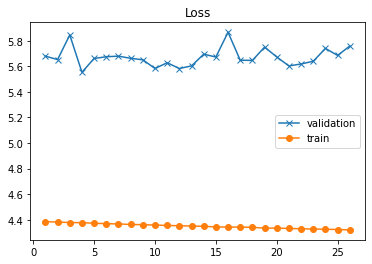

smallest val loss: (4, 5.553672)
Current Lr:  0.00022160554

Time taken for this epoch: 197.84 secs

Epoch 27 Batch 0 Loss 4.1932
Epoch 27 Batch 2 Loss 4.0963
Epoch 27 Batch 4 Loss 4.1040
Epoch 27 Batch 6 Loss 4.1327
Epoch 27 Batch 8 Loss 4.1446
Epoch 27 Batch 10 Loss 4.1484
Epoch 27 Batch 12 Loss 4.1472
Epoch 27 Batch 14 Loss 4.1627
Epoch 27 Batch 16 Loss 4.1715
Epoch 27 Batch 18 Loss 4.1621
Epoch 27 Batch 20 Loss 4.1681
Epoch 27 Batch 22 Loss 4.1756
Epoch 27 Batch 24 Loss 4.1720
Epoch 27 Batch 26 Loss 4.1775
Epoch 27 Batch 28 Loss 4.1826
Epoch 27 Batch 30 Loss 4.1944
Epoch 27 Batch 32 Loss 4.1929
Epoch 27 Batch 34 Loss 4.1910
Epoch 27 Batch 36 Loss 4.1954
Epoch 27 Batch 38 Loss 4.1968
Epoch 27 Batch 40 Loss 4.1921
Epoch 27 Batch 42 Loss 4.1806
Epoch 27 Batch 44 Loss 4.1838
Epoch 27 Batch 46 Loss 4.1902
Epoch 27 Batch 48 Loss 4.1922
Epoch 27 Batch 50 Loss 4.1960
Epoch 27 Batch 52 Loss 4.1937
Epoch 27 Batch 54 Loss 4.1970
Epoch 27 Batch 56 Loss 4.1969
Epoch 27 Batch 58 Loss 4.1987
Epoc

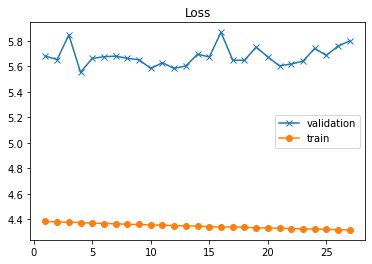

smallest val loss: (4, 5.553672)
Current Lr:  0.00021986195

Time taken for this epoch: 189.76 secs

Epoch 28 Batch 0 Loss 4.2109
Epoch 28 Batch 2 Loss 4.1805
Epoch 28 Batch 4 Loss 4.1848
Epoch 28 Batch 6 Loss 4.1759
Epoch 28 Batch 8 Loss 4.1521
Epoch 28 Batch 10 Loss 4.1404
Epoch 28 Batch 12 Loss 4.1424
Epoch 28 Batch 14 Loss 4.1510
Epoch 28 Batch 16 Loss 4.1567
Epoch 28 Batch 18 Loss 4.1607
Epoch 28 Batch 20 Loss 4.1662
Epoch 28 Batch 22 Loss 4.1701
Epoch 28 Batch 24 Loss 4.1719
Epoch 28 Batch 26 Loss 4.1747
Epoch 28 Batch 28 Loss 4.1760
Epoch 28 Batch 30 Loss 4.1710
Epoch 28 Batch 32 Loss 4.1777
Epoch 28 Batch 34 Loss 4.1743
Epoch 28 Batch 36 Loss 4.1794
Epoch 28 Batch 38 Loss 4.1860
Epoch 28 Batch 40 Loss 4.1859
Epoch 28 Batch 42 Loss 4.1823
Epoch 28 Batch 44 Loss 4.1838
Epoch 28 Batch 46 Loss 4.1861
Epoch 28 Batch 48 Loss 4.1903
Epoch 28 Batch 50 Loss 4.1883
Epoch 28 Batch 52 Loss 4.1860
Epoch 28 Batch 54 Loss 4.1865
Epoch 28 Batch 56 Loss 4.1868
Epoch 28 Batch 58 Loss 4.1864
Epoc

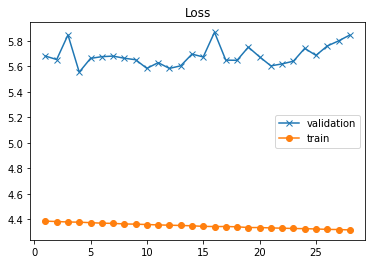

smallest val loss: (4, 5.553672)
Current Lr:  0.00021813207

Time taken for this epoch: 191.46 secs

Epoch 29 Batch 0 Loss 4.2372
Epoch 29 Batch 2 Loss 4.2372
Epoch 29 Batch 4 Loss 4.2321
Epoch 29 Batch 6 Loss 4.2480
Epoch 29 Batch 8 Loss 4.2510
Epoch 29 Batch 10 Loss 4.2314
Epoch 29 Batch 12 Loss 4.2328
Epoch 29 Batch 14 Loss 4.2303
Epoch 29 Batch 16 Loss 4.2171
Epoch 29 Batch 18 Loss 4.2114
Epoch 29 Batch 20 Loss 4.2149
Epoch 29 Batch 22 Loss 4.2051
Epoch 29 Batch 24 Loss 4.2036
Epoch 29 Batch 26 Loss 4.2027
Epoch 29 Batch 28 Loss 4.2053
Epoch 29 Batch 30 Loss 4.2022
Epoch 29 Batch 32 Loss 4.1955
Epoch 29 Batch 34 Loss 4.1931
Epoch 29 Batch 36 Loss 4.1975
Epoch 29 Batch 38 Loss 4.1976
Epoch 29 Batch 40 Loss 4.1983
Epoch 29 Batch 42 Loss 4.2000
Epoch 29 Batch 44 Loss 4.1961
Epoch 29 Batch 46 Loss 4.1960
Epoch 29 Batch 48 Loss 4.1959
Epoch 29 Batch 50 Loss 4.1948
Epoch 29 Batch 52 Loss 4.1991
Epoch 29 Batch 54 Loss 4.1998
Epoch 29 Batch 56 Loss 4.1997
Epoch 29 Batch 58 Loss 4.2004
Epoc

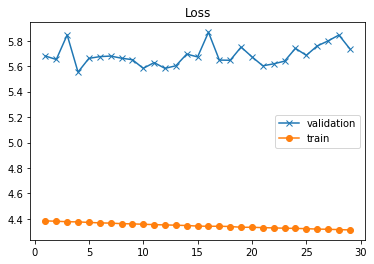

smallest val loss: (4, 5.553672)
Current Lr:  0.00021641579

Time taken for this epoch: 192.23 secs

Epoch 30 Batch 0 Loss 4.2058
Epoch 30 Batch 2 Loss 4.2620
Epoch 30 Batch 4 Loss 4.1961
Epoch 30 Batch 6 Loss 4.1978
Epoch 30 Batch 8 Loss 4.2059
Epoch 30 Batch 10 Loss 4.2138
Epoch 30 Batch 12 Loss 4.2128
Epoch 30 Batch 14 Loss 4.1966
Epoch 30 Batch 16 Loss 4.1968
Epoch 30 Batch 18 Loss 4.1958
Epoch 30 Batch 20 Loss 4.2017
Epoch 30 Batch 22 Loss 4.1994
Epoch 30 Batch 24 Loss 4.2050
Epoch 30 Batch 26 Loss 4.2038
Epoch 30 Batch 28 Loss 4.2077
Epoch 30 Batch 30 Loss 4.2058
Epoch 30 Batch 32 Loss 4.2059
Epoch 30 Batch 34 Loss 4.2047
Epoch 30 Batch 36 Loss 4.2004
Epoch 30 Batch 38 Loss 4.1994
Epoch 30 Batch 40 Loss 4.1926
Epoch 30 Batch 42 Loss 4.2003
Epoch 30 Batch 44 Loss 4.2023
Epoch 30 Batch 46 Loss 4.2004
Epoch 30 Batch 48 Loss 4.1971
Epoch 30 Batch 50 Loss 4.1938
Epoch 30 Batch 52 Loss 4.1930
Epoch 30 Batch 54 Loss 4.1933
Epoch 30 Batch 56 Loss 4.1957
Epoch 30 Batch 58 Loss 4.1943
Epoc

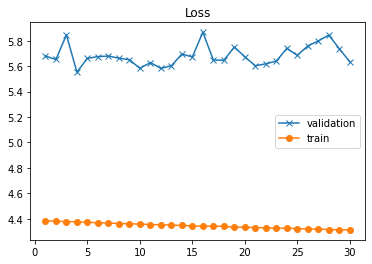

smallest val loss: (4, 5.553672)
Current Lr:  0.00021471303

Time taken for this epoch: 195.88 secs

Epoch 31 Batch 0 Loss 4.1047
Epoch 31 Batch 2 Loss 4.1642
Epoch 31 Batch 4 Loss 4.1501
Epoch 31 Batch 6 Loss 4.1967
Epoch 31 Batch 8 Loss 4.2112
Epoch 31 Batch 10 Loss 4.1712
Epoch 31 Batch 12 Loss 4.1693
Epoch 31 Batch 14 Loss 4.1502
Epoch 31 Batch 16 Loss 4.1525
Epoch 31 Batch 18 Loss 4.1484
Epoch 31 Batch 20 Loss 4.1416
Epoch 31 Batch 22 Loss 4.1350
Epoch 31 Batch 24 Loss 4.1396
Epoch 31 Batch 26 Loss 4.1350
Epoch 31 Batch 28 Loss 4.1418
Epoch 31 Batch 30 Loss 4.1461
Epoch 31 Batch 32 Loss 4.1429
Epoch 31 Batch 34 Loss 4.1491
Epoch 31 Batch 36 Loss 4.1533
Epoch 31 Batch 38 Loss 4.1548
Epoch 31 Batch 40 Loss 4.1618
Epoch 31 Batch 42 Loss 4.1705
Epoch 31 Batch 44 Loss 4.1709
Epoch 31 Batch 46 Loss 4.1689
Epoch 31 Batch 48 Loss 4.1694
Epoch 31 Batch 50 Loss 4.1765
Epoch 31 Batch 52 Loss 4.1764
Epoch 31 Batch 54 Loss 4.1770
Epoch 31 Batch 56 Loss 4.1770
Epoch 31 Batch 58 Loss 4.1769
Epoc

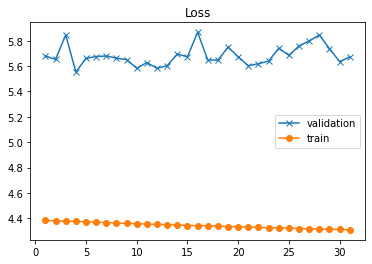

smallest val loss: (4, 5.553672)
Current Lr:  0.00021302364

Time taken for this epoch: 194.20 secs

Epoch 32 Batch 0 Loss 4.1158
Epoch 32 Batch 2 Loss 4.1939
Epoch 32 Batch 4 Loss 4.2244
Epoch 32 Batch 6 Loss 4.2171
Epoch 32 Batch 8 Loss 4.2069
Epoch 32 Batch 10 Loss 4.1988
Epoch 32 Batch 12 Loss 4.1869
Epoch 32 Batch 14 Loss 4.1646
Epoch 32 Batch 16 Loss 4.1556
Epoch 32 Batch 18 Loss 4.1529
Epoch 32 Batch 20 Loss 4.1657
Epoch 32 Batch 22 Loss 4.1695
Epoch 32 Batch 24 Loss 4.1657
Epoch 32 Batch 26 Loss 4.1730
Epoch 32 Batch 28 Loss 4.1758
Epoch 32 Batch 30 Loss 4.1809
Epoch 32 Batch 32 Loss 4.1859
Epoch 32 Batch 34 Loss 4.1848
Epoch 32 Batch 36 Loss 4.1851
Epoch 32 Batch 38 Loss 4.1909
Epoch 32 Batch 40 Loss 4.1896
Epoch 32 Batch 42 Loss 4.1873
Epoch 32 Batch 44 Loss 4.1892
Epoch 32 Batch 46 Loss 4.1908
Epoch 32 Batch 48 Loss 4.1908
Epoch 32 Batch 50 Loss 4.1897
Epoch 32 Batch 52 Loss 4.1910
Epoch 32 Batch 54 Loss 4.1911
Epoch 32 Batch 56 Loss 4.1935
Epoch 32 Batch 58 Loss 4.1918
Epoc

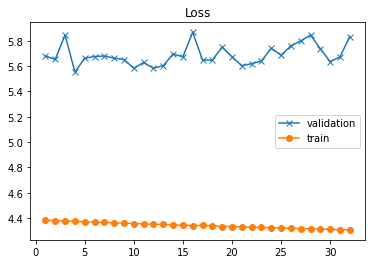

smallest val loss: (4, 5.553672)
Current Lr:  0.00021134756

Time taken for this epoch: 190.93 secs

Epoch 33 Batch 0 Loss 4.1706
Epoch 33 Batch 2 Loss 4.1617
Epoch 33 Batch 4 Loss 4.1425
Epoch 33 Batch 6 Loss 4.1518
Epoch 33 Batch 8 Loss 4.1648
Epoch 33 Batch 10 Loss 4.1781
Epoch 33 Batch 12 Loss 4.1903
Epoch 33 Batch 14 Loss 4.1933
Epoch 33 Batch 16 Loss 4.1931
Epoch 33 Batch 18 Loss 4.1964
Epoch 33 Batch 20 Loss 4.1958
Epoch 33 Batch 22 Loss 4.1949
Epoch 33 Batch 24 Loss 4.2006
Epoch 33 Batch 26 Loss 4.1995
Epoch 33 Batch 28 Loss 4.1998
Epoch 33 Batch 30 Loss 4.2020
Epoch 33 Batch 32 Loss 4.2013
Epoch 33 Batch 34 Loss 4.2081
Epoch 33 Batch 36 Loss 4.2178
Epoch 33 Batch 38 Loss 4.2219
Epoch 33 Batch 40 Loss 4.2170
Epoch 33 Batch 42 Loss 4.2136
Epoch 33 Batch 44 Loss 4.2085
Epoch 33 Batch 46 Loss 4.2102
Epoch 33 Batch 48 Loss 4.2103
Epoch 33 Batch 50 Loss 4.2112
Epoch 33 Batch 52 Loss 4.2084
Epoch 33 Batch 54 Loss 4.2102
Epoch 33 Batch 56 Loss 4.2107
Epoch 33 Batch 58 Loss 4.2057
Epoc

KeyboardInterrupt: ignored

In [ ]:
print(params)
print('#'*40)

for epoch in range(ep,EPOCHS+1):
    ep = epoch
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        
        train_step(inp, tar)
    
        if batch % 2 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch , batch, train_loss.result()))
                  
    print()
    print(summarize(clean_words(longreview_val['long'][i1])))
    print(summarize(clean_words(longreview_val['long'][i2])))
    print(summarize(clean_words(longreview_val['long'][i3])))
    print(summarize(clean_words(longreview_val['long'][i4])))
    print()
    
    val_loss_ = validate().numpy()
    history['val'].append((epoch,val_loss_))
    print ('\n* Train Loss {:.4f}'.format(train_loss.result()))
    history['train'].append((epoch,train_loss.result().numpy()))
    
    
    if best_val_loss-val_loss_ > 0.1:
        ckpt_save_path4 = ckpt_manager4.save()
        print ('\nSaving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path4))  
        best_val_loss = val_loss_
    
    hist(history)
    print('Current Lr: ',optimizer2._decayed_lr('float32').numpy())
    print ('\nTime taken for this epoch: {:.2f} secs\n'.format(time.time() - start))
    print('='*40)

output removed to reduce file size for github

In [ ]:
ckpt_save_path4 = ckpt_manager4.save()

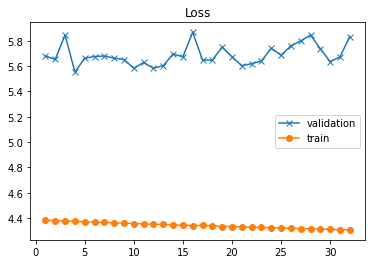

smallest val loss: (4, 5.553672)


{'lmbda_l2': 0.2,
 'd_out_rate': 0.2,
 'num_layers': 5,
 'd_model': 100,
 'dff': 512,
 'num_heads': 5,
 'init_lr': 0.001}

In [ ]:
hist(history)
params

you can use more data or more regularization to avoid the overfitting 

In [ ]:
example_text = '''Cristiano Ronaldo dos Santos Aveiro GOIH ComM (Portuguese pronunciation: [kɾiʃˈtjɐnu ʁɔˈnaɫdu]; born 5 February 1985) is a Portuguese professional footballer who plays as a forward for Premier League club Manchester United and captains the Portugal national team. Widely regarded as one of the greatest players of all time, Ronaldo has won five Ballon d'Or awards[note 3] and four European Golden Shoes, the most by a European player. He has won 32 trophies in his career, including seven league titles, five UEFA Champions Leagues, and the UEFA European Championship. Ronaldo holds the records for most appearances (183), goals (140), and assists (42) in the Champions League, goals in the European Championship (14), international goals (117), and international appearances by a European (189). He is one of the few players to have made over 1,100 professional career appearances, and has scored over 800 official senior career goals for club and country.'''

In [ ]:
print(summarize(clean_words(example_text)))

is the only player since he played for the club since
